# Fine Tuning BERT for Sentiment Analysis with PyTorch

The only difference between this notebook and [train.ipynb](./train.ipynb) is that this version freezes
the BERTimbau Layers

References:
- [Fine Tuning BERT for Sentiment Analysis with PyTorch](https://wellsr.com/python/fine-tuning-bert-for-sentiment-analysis-with-pytorch/)
- [Twitter US Airline Sentiment](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment?select=Tweets.csv)

- [RuntimeError: CUDA out of memory during loss.backward()](https://discuss.pytorch.org/t/runtimeerror-cuda-out-of-memory-during-loss-backward/53450/6)
- [Forms - Colaboratory](https://colab.research.google.com/notebooks/forms.ipynb)
- [Plotting loss curve](https://discuss.pytorch.org/t/plotting-loss-curve/42632/5)
- [Estratégias eficazes para lidar com conjuntos de dados desbalanceados](https://medium.com/@daniele.santiago/estrat%C3%A9gias-eficazes-para-lidar-com-conjuntos-de-dados-desbalanceados-5b873894483b)
- [Aprenda a balancear seus dados com Undersampling e Oversampling em Python](https://medium.com/@daniele.santiago/aprenda-a-balancear-seus-dados-com-undersampling-e-oversampling-em-python-6fd87095d717#:~:text=J%C3%A1%20o%20over%2Dsampling%2C%20por,t%C3%A9cnicas%20foi%20explicitada%20neste%20artigo.)
- [RandomOverSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler.fit_resample)
- [REPRODUCIBILITY](https://pytorch.org/docs/stable/notes/randomness.html)

In [2]:
# @title Environment running
running_local = False
if running_local:
    running_colab = running_kaggle = False
else:
    running_colab = False  # @param {type:"boolean"}
    running_kaggle = not running_colab  # @param {type:"boolean"}

In [3]:
if running_colab:
    from google.colab import drive

    drive.mount("/content/drive")

## Installing and Importing Required Libraries

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

## Config

In [52]:
RANDOM_SEED = 103
TEST_SIZE = 0.2
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 5

TOKEN_MAX_LENGTH = 512
MODEL_PATH = "neuralmind/bert-base-portuguese-cased"
if running_colab:
    GLASSDOOR_MODEL_PATH = "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/train_model/bertimbau-glassdoor-reviews-no-hidden-layer_epoch_5.bin"
    PATH_TO_SAVE_MODEL = "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/train_model/"
if running_kaggle:
    GLASSDOOR_MODEL_PATH = "/kaggle/working/bertimbau-glassdoor-reviews-no-hidden-layer-epoch_5.bin"
    PATH_TO_SAVE_MODEL = "/kaggle/working/"
if running_local:
    GLASSDOOR_MODEL_PATH = "./bertimbau-glassdoor-reviews-no-hidden-layer_epoch_5.bin"
    PATH_TO_SAVE_MODEL = "./train_model/"

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [7]:
torch.manual_seed(RANDOM_SEED)

In [8]:
random.seed(RANDOM_SEED)

In [9]:
np.random.seed(RANDOM_SEED)

## Importing and Preprocessing the Dataset

In [10]:
if running_colab:
    dataset = pd.read_csv(
        "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/data_preparation/glassdoor_reviews_annotated.csv"
    )
else:
    if running_kaggle:
        dataset = pd.read_csv(
            "/kaggle/input/glassdoor-reviews-annotated2/glassdoor_reviews_annotated.csv"
        )
    else:
        dataset = pd.read_csv("../data_preparation/glassdoor_reviews_annotated.csv")

In [11]:
dataset.head(2)

,review_id,company,employee_role,employee_detail,review_text,review_date,star_rating,sentiment,annotated
0,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano","Companheirismo entre os colegas, oportunidade ...",2023-12-15,5.0,1,0
1,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano",Não tive nenhum ponto negativo,2023-12-15,5.0,0,1


In [12]:
filtered_dataset = dataset.filter(["review_text", "sentiment"])

In [13]:
filtered_dataset.shape

(2532, 2)

In [14]:
filtered_dataset["sentiment"].value_counts()

sentiment
 1    1269
-1    1021
 0     242
Name: count, dtype: int64

In [15]:
num_labels = len(filtered_dataset["sentiment"].value_counts())

In [16]:
num_labels

3

In [17]:
filtered_dataset.head()

,review_text,sentiment
0,"Companheirismo entre os colegas, oportunidade ...",1
1,Não tive nenhum ponto negativo,0
2,Equipe bem prestativa e ótima de se trabalhar.,1
3,Modo home office ainda tem que ser melhorado.,-1
4,Única vantagem era o trabalho ser home office,0


Replace negative sentiment (-1) to 2, to avoid PyTorch errors.

In [18]:
filtered_dataset["sentiment"] = filtered_dataset["sentiment"].apply(
    lambda x: 2 if x == -1 else x
)

In [19]:
filtered_dataset.head()

,review_text,sentiment
0,"Companheirismo entre os colegas, oportunidade ...",1
1,Não tive nenhum ponto negativo,0
2,Equipe bem prestativa e ótima de se trabalhar.,1
3,Modo home office ainda tem que ser melhorado.,2
4,Única vantagem era o trabalho ser home office,0


Shuffle the data before splitting it into training and testing sets to remove any inherent ordering in the data that could bias the model's learning process.

In [20]:
filtered_dataset = filtered_dataset.sample(frac=1, random_state=RANDOM_SEED)

In [21]:
train_data, test_data = train_test_split(
    filtered_dataset, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

In [22]:
train_data.shape

(2025, 2)

In [23]:
test_data.shape

(507, 2)

## Create a PyTorch Dataset

In [24]:
class GlassdoorReviewsDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = TOKEN_MAX_LENGTH

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]["review_text"]
        labels = self.data.iloc[index][["sentiment"]].values.astype(int)

        encoding = self.tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=False,
            # max_length=self.max_length,
        )
        input_ids = encoding["input_ids"][0]
        attention_mask = encoding["attention_mask"][0]

        # resize the tensors to the same size
        input_ids = nn.functional.pad(
            input_ids, (0, self.max_length - input_ids.shape[0]), value=0
        )
        attention_mask = nn.functional.pad(
            attention_mask, (0, self.max_length - attention_mask.shape[0]), value=0
        )

        return input_ids, attention_mask, torch.tensor(labels)

In [25]:
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

In [26]:
train_dataset = GlassdoorReviewsDataset(train_data, tokenizer)
test_dataset = GlassdoorReviewsDataset(test_data, tokenizer)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Creating a PyTorch Model

In [28]:
class GlassdoorReviewsClassifier(nn.Module):
    def __init__(self, num_labels):
        super(GlassdoorReviewsClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_PATH)

        # Freeze BERT layers
        for param in self.bert.parameters():
            param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, num_labels),
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs["last_hidden_state"][:, 0, :]
        x = self.classifier(x)
        return x

## Model training functions

In [29]:
def train(model, data_loader, loss_fun, optimizer, n_total_steps):
    model.train()

    running_loss = 0.0
    for i, batch in enumerate(data_loader):
        input_ids, attention_mask, labels = batch

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        labels = labels.view(-1)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(input_ids, attention_mask)

        loss = loss_fun(logits, labels)

        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        if (i + 1) % BATCH_SIZE == 0:
            print(
                f"Training Batch {i + 1}/{n_total_steps}, \t\t loss = {loss_value:.4f}"
            )

    return running_loss / len(data_loader)

In [30]:
def test(model, data_loader, loss_fun, n_total_steps):
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            labels = labels.view(-1)
            labels = labels.to(device)

            logits = model(input_ids, attention_mask)
            loss = loss_fun(logits, labels)

            loss_value = loss.item()
            running_loss += loss_value

            if (i + 1) % BATCH_SIZE == 0:
                print(
                    f"Evaluating Batch {i + 1}/{n_total_steps}, \t\t loss = {loss_value:.4f}"
                )

    return running_loss / len(data_loader)

In [31]:
def show_loss(train_loss_per_epoch, test_loss_per_epoch):
    epochs = range(1, len(train_loss_per_epoch) + 1)

    train_data = {"epoch": epochs, "loss": train_loss_per_epoch, "type": "Train"}
    test_data = {"epoch": epochs, "loss": test_loss_per_epoch, "type": "Test"}
    df_loss = pd.concat([pd.DataFrame(train_data), pd.DataFrame(test_data)])

    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df_loss, x="epoch", y="loss", hue="type", marker="o")

    plt.title("Training and Test Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # plt.grid(True)
    plt.legend(title="Loss Type")
    plt.show()

In [32]:
def start_training(model, train_loader, loss_fun, optimizer, epochs, n_total_steps):
    train_losses = []
    test_losses = []

    for t in range(epochs):
        print(f"{'-'*20} Epoch: {t + 1}/{epochs} {'-'*20}")

        train_loss = train(model, train_loader, loss_fun, optimizer, n_total_steps)
        train_losses.append(train_loss)

        print("")

        test_loss = test(model, test_loader, loss_fun, n_total_steps)
        test_losses.append(test_loss)

        print(f"\nTrain Loss: {train_loss}, \t\t Test Loss: {test_loss}")
        print("\n\n")

    return train_losses, test_losses

## Model Evaluation functions

In [33]:
def evaluate_model(model, test_loader, device):
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            labels = labels.view(-1)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            _, predictions = torch.max(outputs, 1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(predictions.cpu().numpy())

    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    return all_labels, all_preds

In [34]:
def show_confusion_matrix(all_labels, all_preds, normalize=None):
    cm = confusion_matrix(all_labels, all_preds, normalize=normalize)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [35]:
def predict_reviews(model, reviews) -> None:
    class_names = ["neutral", "positive", "negative"]
    for review in reviews:
        encoded_review = tokenizer.encode_plus(
            review,
            max_length=TOKEN_MAX_LENGTH,
            add_special_tokens=True,
            return_token_type_ids=False,
            # pad_to_max_length=True, # deprecated
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        input_ids = encoded_review["input_ids"].to(device)
        attention_mask = encoded_review["attention_mask"].to(device)

        output = model(input_ids, attention_mask)
        _, prediction = torch.max(output, dim=1)
        probs = nn.functional.softmax(output, dim=1)

        print(f"Review text: {review}")
        # print(probs)
        print(pd.DataFrame(probs.tolist()[0], class_names)[0])
        print("\n")

    return None

## Training the Model (without oversampling)

### Training the Model

In [36]:
model = GlassdoorReviewsClassifier(num_labels).to(device)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [37]:
loss_fun = nn.CrossEntropyLoss()

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [39]:
n_total_steps = len(train_loader)
n_total_steps

127

In [40]:
train_losses, test_losses = start_training(
    model, train_loader, loss_fun, optimizer, EPOCHS, n_total_steps
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/127, 		 loss = 1.0367
Training Batch 32/127, 		 loss = 1.0639
Training Batch 48/127, 		 loss = 1.2376
Training Batch 64/127, 		 loss = 1.1271
Training Batch 80/127, 		 loss = 1.1418
Training Batch 96/127, 		 loss = 1.1201
Training Batch 112/127, 		 loss = 1.1321

Evaluating Batch 16/127, 		 loss = 1.0632
Evaluating Batch 32/127, 		 loss = 0.9541

Train Loss: 1.1052465528015076, 		 Test Loss: 1.015996901318431



-------------------- Epoch: 2/5 --------------------
Training Batch 16/127, 		 loss = 1.0430
Training Batch 32/127, 		 loss = 0.9195
Training Batch 48/127, 		 loss = 1.0352
Training Batch 64/127, 		 loss = 0.9271
Training Batch 80/127, 		 loss = 0.9222
Training Batch 96/127, 		 loss = 1.1141
Training Batch 112/127, 		 loss = 0.9709

Evaluating Batch 16/127, 		 loss = 1.0005
Evaluating Batch 32/127, 		 loss = 0.8785

Train Loss: 0.9994111084562587, 		 Test Loss: 0.9334954675287008



-------------------- Epoc

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

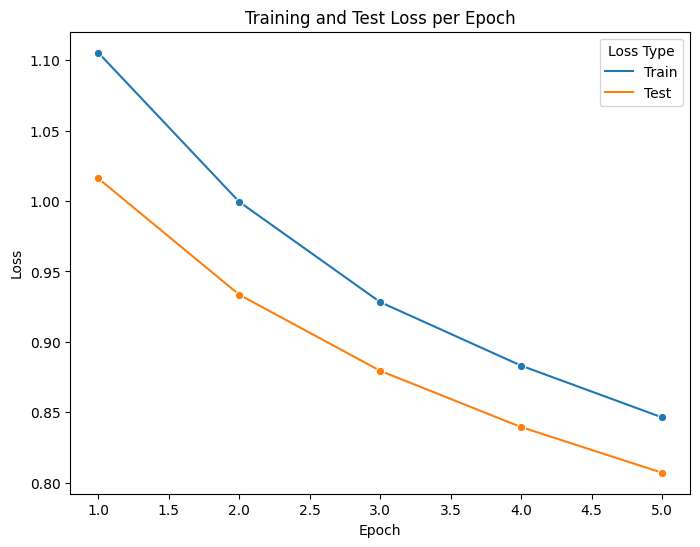

In [41]:
show_loss(train_losses, test_losses)

### Evaluating the Model

In [42]:
all_labels, all_preds = evaluate_model(model, test_loader, device)

In [43]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
           1       0.64      0.98      0.77       269
           2       0.81      0.40      0.54       187

    accuracy                           0.67       507
   macro avg       0.48      0.46      0.44       507
weighted avg       0.64      0.67      0.61       507



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
print(accuracy_score(all_labels, all_preds))

0.6686390532544378


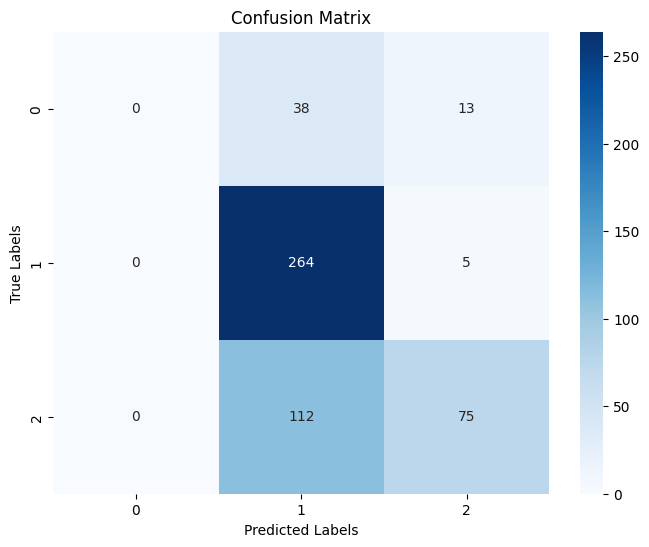

In [45]:
show_confusion_matrix(all_labels, all_preds)

In [46]:
# show_confusion_matrix(all_labels, all_preds, normalize="true")

### Saving the model

In [47]:
torch.save(model.state_dict(), f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-no-hidden-layer-epoch_{EPOCHS}.bin")

### Loading the model

In [48]:
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

In [53]:
loaded_model = GlassdoorReviewsClassifier(num_labels).to(device)
loaded_model.load_state_dict(torch.load(GLASSDOOR_MODEL_PATH, map_location=device))
loaded_model.eval()

GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

### Sample prediction

In [54]:
reviews = [
    "Empresa boa para trabalhar",
    "Empresa ruim para trabalhar",
    "Não tenho o que declarar",
]

In [55]:
predict_reviews(model, reviews)

Review text: Empresa boa para trabalhar
neutral     0.101441
positive    0.579977
negative    0.318582
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.106194
positive    0.512864
negative    0.380942
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.209104
positive    0.377698
negative    0.413197
Name: 0, dtype: float64




## Training the model (with oversampling)

### Oversampling

In [56]:
def oversampling(train_df, minority_class=0, majority_classes=[1, 2]):
    # Desired number of samples for the minority class
    oversample_size = (
        train_df[train_df["sentiment"] == 0]["sentiment"].value_counts()[0] * 3
    )

    oversampler = RandomOverSampler(sampling_strategy={minority_class: oversample_size})
    X_res, y_res = oversampler.fit_resample(
        train_df[["review_text"]], train_df["sentiment"]
    )

    y_res_df = pd.DataFrame({"sentiment": y_res})
    resampled_df = pd.concat([X_res, y_res_df], axis=1)
    resampled_df.reset_index(drop=True, inplace=True)

    resampled_minority_df = resampled_df[resampled_df["sentiment"] == minority_class]

    # Concatenate the oversampled minority class with the majority class
    oversampled_df = pd.concat([train_df, resampled_minority_df])

    # Shuffle the DataFrame to randomize the order of samples
    oversampled_df = oversampled_df.sample(
        frac=1, random_state=RANDOM_SEED
    ).reset_index(drop=True)
    return oversampled_df

In [57]:
filtered_dataset.shape

(2532, 2)

In [58]:
filtered_dataset["sentiment"].value_counts()

sentiment
1    1269
2    1021
0     242
Name: count, dtype: int64

In [59]:
oversampled_filtered_dataset = oversampling(filtered_dataset)

In [60]:
oversampled_filtered_dataset.shape

(3258, 2)

In [61]:
oversampled_filtered_dataset["sentiment"].value_counts()

sentiment
1    1269
2    1021
0     968
Name: count, dtype: int64

### Training the Model

In [62]:
oversampled_train_data, oversampled_test_data = train_test_split(
    oversampled_filtered_dataset, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

In [63]:
oversampled_train_dataset = GlassdoorReviewsDataset(oversampled_train_data, tokenizer)
oversampled_test_dataset = GlassdoorReviewsDataset(oversampled_test_data, tokenizer)

In [64]:
oversampled_train_loader = DataLoader(
    oversampled_train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
oversampled_test_loader = DataLoader(
    oversampled_test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [65]:
oversampled_model = GlassdoorReviewsClassifier(num_labels).to(device)

In [66]:
loss_fun = nn.CrossEntropyLoss()

In [67]:
oversampled_optimizer = torch.optim.Adam(
    oversampled_model.parameters(), lr=LEARNING_RATE
)

In [68]:
n_total_steps = len(oversampled_train_loader)
n_total_steps

163

In [69]:
oversampled_train_losses, oversampled_test_losses = start_training(
    oversampled_model,
    oversampled_train_loader,
    loss_fun,
    oversampled_optimizer,
    EPOCHS,
    n_total_steps,
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/163, 		 loss = 1.1446
Training Batch 32/163, 		 loss = 1.0987
Training Batch 48/163, 		 loss = 1.1346
Training Batch 64/163, 		 loss = 1.0746
Training Batch 80/163, 		 loss = 1.0980
Training Batch 96/163, 		 loss = 1.0517
Training Batch 112/163, 		 loss = 1.0740
Training Batch 128/163, 		 loss = 1.0619
Training Batch 144/163, 		 loss = 1.0310
Training Batch 160/163, 		 loss = 1.0515

Evaluating Batch 16/163, 		 loss = 1.0327
Evaluating Batch 32/163, 		 loss = 0.9801

Train Loss: 1.0873091593841833, 		 Test Loss: 1.029058376327157



-------------------- Epoch: 2/5 --------------------
Training Batch 16/163, 		 loss = 1.0914
Training Batch 32/163, 		 loss = 1.0841
Training Batch 48/163, 		 loss = 0.9906
Training Batch 64/163, 		 loss = 1.0663
Training Batch 80/163, 		 loss = 1.0669
Training Batch 96/163, 		 loss = 1.0430
Training Batch 112/163, 		 loss = 1.0289
Training Batch 128/163, 		 loss = 1.0330
Training Batch 

### Evaluating the Model

In [70]:
len(oversampled_train_losses)

5

In [71]:
len(oversampled_test_losses)

5

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

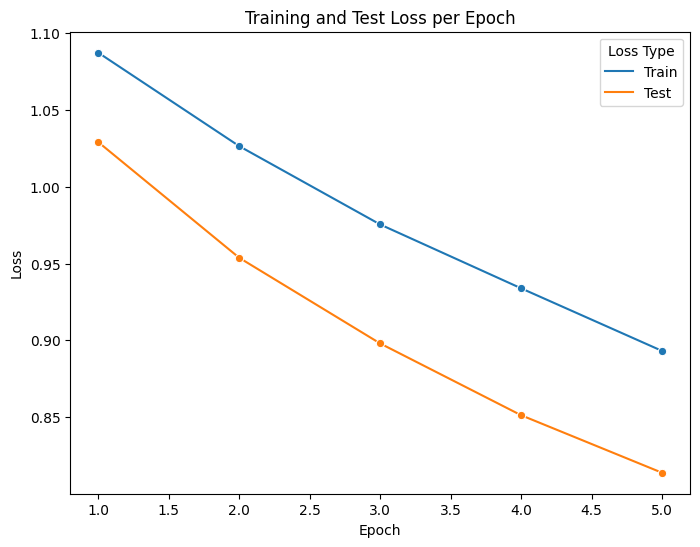

In [72]:
show_loss(oversampled_train_losses, oversampled_test_losses)

In [73]:
oversampled_all_labels, oversampled_all_preds = evaluate_model(
    oversampled_model, oversampled_test_loader, device
)

In [74]:
print(classification_report(oversampled_all_labels, oversampled_all_preds))

              precision    recall  f1-score   support

           0       0.87      0.59      0.71       197
           1       0.64      0.96      0.77       256
           2       0.88      0.58      0.70       199

    accuracy                           0.73       652
   macro avg       0.80      0.71      0.72       652
weighted avg       0.78      0.73      0.73       652



In [75]:
print(accuracy_score(oversampled_all_labels, oversampled_all_preds))

0.7331288343558282


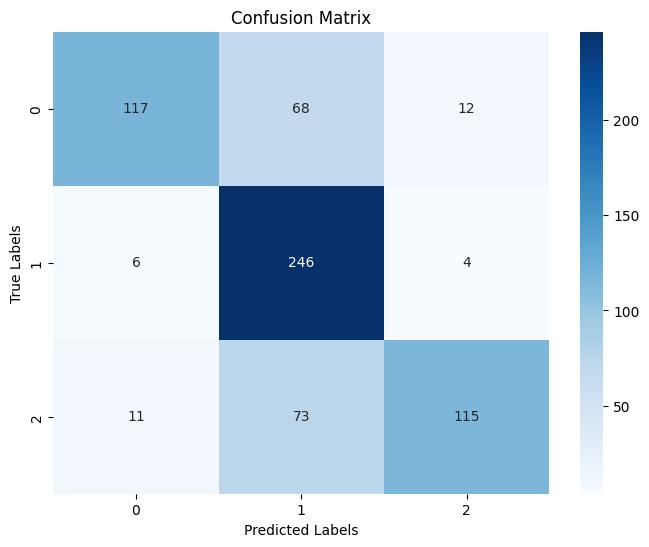

In [76]:
show_confusion_matrix(oversampled_all_labels, oversampled_all_preds)

### Saving the model

In [77]:
torch.save(
    oversampled_model.state_dict(),
    f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-oversampled-no-hidden-layer-epoch_{EPOCHS}.bin",
)

### Loading the model

In [78]:
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

In [79]:
oversampled_model = GlassdoorReviewsClassifier(num_labels).to(device)
oversampled_model.load_state_dict(
    torch.load(
        GLASSDOOR_MODEL_PATH.replace(
            f"bertimbau-glassdoor-reviews-no-hidden-layer_epoch_5.bin",
            f"bertimbau-glassdoor-reviews-oversampled-no-hidden-layer-epoch_{EPOCHS}.bin",
        ),
        map_location=device,
    )
)
oversampled_model.eval()

GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

## Sample prediction

In [80]:
reviews = [
    "Empresa boa para trabalhar",
    "Empresa ruim para trabalhar",
    "Não tenho o que declarar",
]

In [81]:
predict_reviews(oversampled_model, reviews)

Review text: Empresa boa para trabalhar
neutral     0.101441
positive    0.579977
negative    0.318582
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.106194
positive    0.512864
negative    0.380942
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.209104
positive    0.377698
negative    0.413197
Name: 0, dtype: float64


